✅ Success: Dataset loaded.
ℹ️ Columns found: ['_id', 'occupancy_date', 'organization_id', 'organization_name', 'shelter_id', 'shelter_group', 'location_id', 'location_name', 'location_address', 'location_postal_code', 'location_city', 'location_province', 'program_id', 'program_name', 'sector', 'program_model', 'overnight_service_type', 'program_area', 'service_user_count', 'capacity_type', 'capacity_actual_bed', 'capacity_funding_bed', 'occupied_beds', 'unoccupied_beds', 'unavailable_beds', 'capacity_actual_room', 'capacity_funding_room', 'occupied_rooms', 'unoccupied_rooms', 'unavailable_rooms', 'occupancy_rate_beds', 'occupancy_rate_rooms']
🎯 MAPPED: Capacity='capacity_actual_bed' | Occupancy='occupied_beds'
✅ Data Ready. Records: 34766
📊 Generating Chart...


C:\Users\user\AppData\Local\Temp\ipykernel_11804\1915042104.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sector_strain, x=group_col, y='occupancy_rate', palette='viridis')


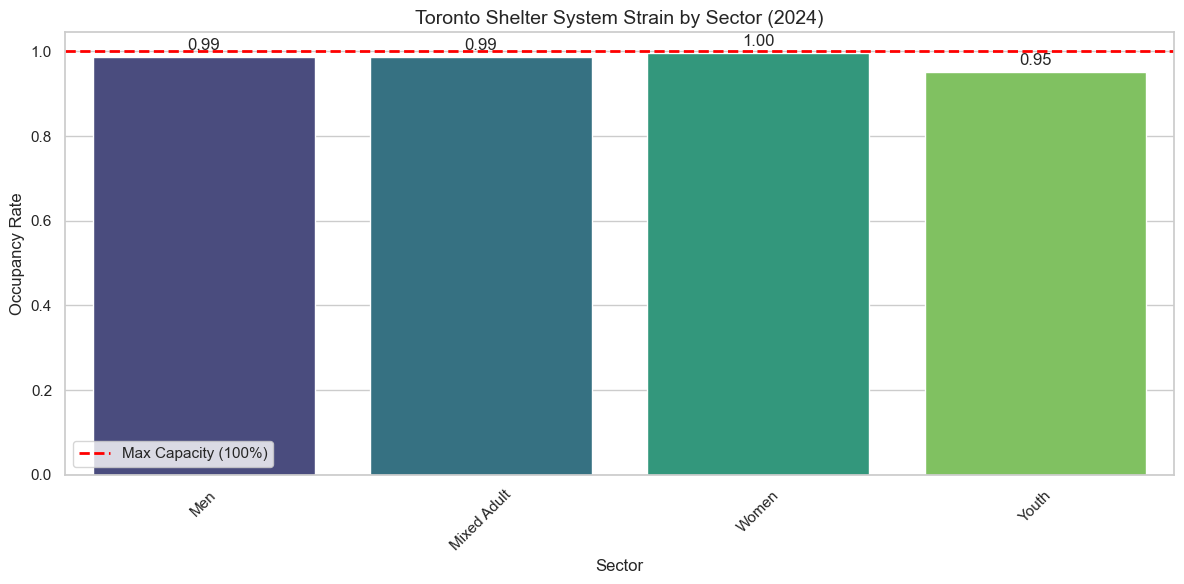

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURATION ---
FILE_NAME = 'shelter_2024.csv' 

# Visual Setup
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 2. DATA LOADING & PROCESSING ---
try:
    # Load Data
    df = pd.read_csv(FILE_NAME)
    print("✅ Success: Dataset loaded.")
    
    # 1. Clean Column Names
    # Remove spaces, lowercase, replace spaces with underscores
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
    print(f"ℹ️ Columns found: {df.columns.tolist()}")

    # 2. INTELLIGENT COLUMN MAPPING (The Fix)
    # We explicitly look for 'occupied_beds' first.
    
    # Find Capacity Column
    if 'capacity_actual_bed' in df.columns:
        cap_col = 'capacity_actual_bed'
    elif 'capacity_actual' in df.columns:
        cap_col = 'capacity_actual'
    else:
        cap_col = 'capacity'

    # Find Occupancy Column (Targeting 'occupied_beds')
    if 'occupied_beds' in df.columns:
        occ_col = 'occupied_beds'
    elif 'occupancy_actual' in df.columns:
        occ_col = 'occupancy_actual'
    else:
        # Avoid picking 'occupancy_date' by mistake
        possible_cols = [c for c in df.columns if 'occupancy' in c and 'date' not in c]
        occ_col = possible_cols[0] if possible_cols else 'occupancy'

    print(f"🎯 MAPPED: Capacity='{cap_col}' | Occupancy='{occ_col}'")

    # 3. Data Type Conversions
    if 'occupancy_date' in df.columns:
        df['occupancy_date'] = pd.to_datetime(df['occupancy_date'])
    
    # 4. Calculation
    # Fill missing capacity
    df[cap_col].fillna(df[cap_col].median(), inplace=True)
    df = df[df[cap_col] > 0] # Remove zero capacity

    # Calculate Rate
    df['occupancy_rate'] = df[occ_col] / df[cap_col]
    
    # Filter logical errors (Rate > 300%)
    df = df[df['occupancy_rate'] <= 3.0]
    
    print(f"✅ Data Ready. Records: {len(df)}")

    # --- 3. VISUALIZATION ---
    print("📊 Generating Chart...")
    plt.figure(figsize=(12, 6))
    
    # Group by Sector/Group
    # Check if 'sector' exists, otherwise use 'shelter_group' (common in 2024 data)
    group_col = 'sector' if 'sector' in df.columns else 'shelter_group'
    
    sector_strain = df.groupby(group_col)['occupancy_rate'].mean().reset_index()
    
    ax = sns.barplot(data=sector_strain, x=group_col, y='occupancy_rate', palette='viridis')
    plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Max Capacity (100%)')
    
    plt.title(f'Toronto Shelter System Strain by {group_col.title()} (2024)', fontsize=14)
    plt.ylabel('Occupancy Rate')
    plt.xlabel(group_col.title())
    plt.xticks(rotation=45) # Rotate labels if they are long
    plt.legend()
    
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=3)
        
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Critical Error: {e}")